# Beta-project - Using AI to classify climbing problems

In [1]:
import json
import os
import datetime
import time
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as keras

2024-08-28 18:56:06.307278: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-28 18:56:06.465863: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-28 18:56:06.511133: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-28 18:56:06.848852: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-28 18:56:08.797522: W tensorflow/compiler/tf2

## Download and import data

We use an [extracted database](https://github.com/spookykat/MoonBoard/issues/6#issuecomment-1783515787) found on GitHub.

We first download everything and import raw data, except the "problems.json" that mostly contains duplicates of the Masters 2019 dataset.

We include the Mini MoonBoard dataset, as it contains many routes that are still relevant to our problem. The model we'll use will not take into account the size of the route but rather local patterns.

We only include columns that will be relevant for our classification problem, i.e. data that influence a route's grade.

In [ ]:
!wget https://github.com/spookykat/MoonBoard/files/13193317/problems_2023_01_30.zip
!unzip problems_2023_01_30 -d problems_2023_01_30

In [2]:
columns = {
  "apiId": int,
  "name": str,
  "grade": 'category',
  "userGrade": 'category',
  "method": 'category',
  "holdsetup": 'category',
  "holdsets": 'object',
  "moves": 'object',
  "angle": int
}
column_names = list(columns.keys())

df = pd.DataFrame(columns=column_names)

for filename in os.listdir('problems_2023_01_30'):
  if filename == 'problems.json':
    continue
  
  with open(os.path.join('problems_2023_01_30', filename), 'r') as f:
    data = json.load(f)
    local_df = pd.DataFrame(data["data"])
    angle = int(filename.rstrip('.json').split()[-1])
    local_df['angle'] = angle if angle < 90 else 40
    df = pd.concat([df, local_df[column_names]])
      
df.drop_duplicates(keep='first', subset='apiId', inplace=True)
df.set_index('apiId', inplace=True)

## Parsing fields

### Fields with foreign relations

In [3]:
df["holdsetup"] = df["holdsetup"].map(lambda x: x['apiId'])
df["holdsets"] = df["holdsets"].map(lambda sets: [el['apiId'] for el in sets])

### Moves: all holds of the route

There are three types of holds:

- Starter hold: where to put hands at the beginning
- Middle hold
- End hold: where to put both hands for at least 3 seconds at the end of the route

In [4]:
WIDTH = 11
HEIGHT = 18
NUM_HOLD_TYPES = 3

MOVES_SHAPE=(WIDTH, HEIGHT, NUM_HOLD_TYPES)

def parse_holds(moves):
  holds = np.zeros(MOVES_SHAPE, dtype=np.uint8)
  for hold in moves:
    description = hold['description']
    column = ord(description[0].upper()) - ord('A')
    row = int(description[1:]) - 1
    channel = 0
    if hold['isStart']:
      channel = 1
    if hold['isEnd']:
      channel = 2
    holds[column, row, channel] = 1
  return holds


df["moves"] = df["moves"].map(parse_holds)

### Merging "grade" and "userGrade"

When a userGrade is present, it means that enough users rated this route so we assume this is a more objective metric than opener's grade attribution.

In [5]:
df["grade"] = df["userGrade"].combine_first(df["grade"]).astype('category')
df.drop("userGrade", axis=1, inplace=True)

### Putting the right dtypes

In [6]:
for column in df.columns:
  df[column] = df[column].astype(columns[column])

### Empty data

In [7]:
df.isna().sum()

name         0
grade        0
method       0
holdsetup    0
holdsets     0
moves        0
angle        0
dtype: int64

There is no empty data, but one can uncomment the code below if any shows up.

In [8]:
# df.select_dtypes(include=[int, float]).fillna(df.mean(), inplace=True)
# categories = df.select_dtypes(include=['category', 'object'])
# categories.fillna(categories.mode().iloc[0])

## Data Visualization and analysis

### Overall information

In [36]:
df.describe()

,angle
count,143100.000000
mean,38.548952
std,4.433996
min,25.000000
25%,40.000000
50%,40.000000
75%,40.000000
max,40.000000


In [37]:
df['holdsets'].value_counts()

holdsets
[3, 4, 5]          32702
[4, 5]             24720
[4, 5, 8]          12873
[3, 4, 5, 8]        8615
[3, 4, 5, 8, 9]     4963
                   ...  
[5, 9, 11]            53
[10]                  50
[5, 11]               47
[5, 9, 10]            43
[5, 10]               31
Name: count, Length: 78, dtype: int64

In [39]:
df['holdsetup'].value_counts()

holdsetup
1     59506
15    55122
17    24802
19     3670
Name: count, dtype: int64

In [65]:
all_grades = list(df['grade'].cat.categories)
all_grades

['5+',
 '6A',
 '6A+',
 '6B',
 '6B+',
 '6C',
 '6C+',
 '7A',
 '7A+',
 '7B',
 '7B+',
 '7C',
 '7C+',
 '8A',
 '8A+',
 '8B',
 '8B+']

### Visualize routes

We plot some of the routes to better visualize their structure. The plot will not be in the same orientation, due to the array structure: the left side is the bottom of the route.

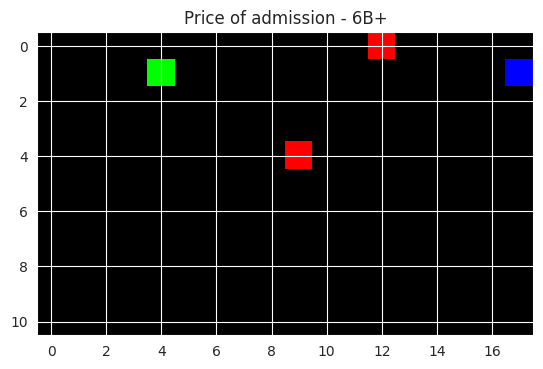

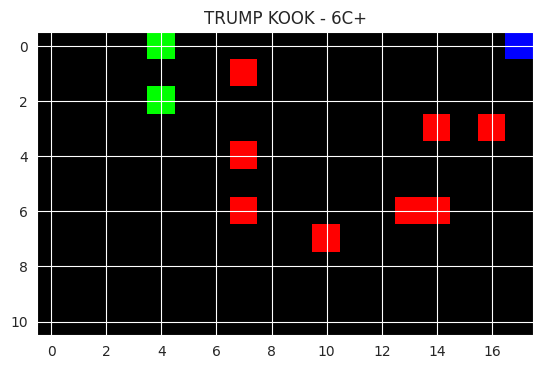

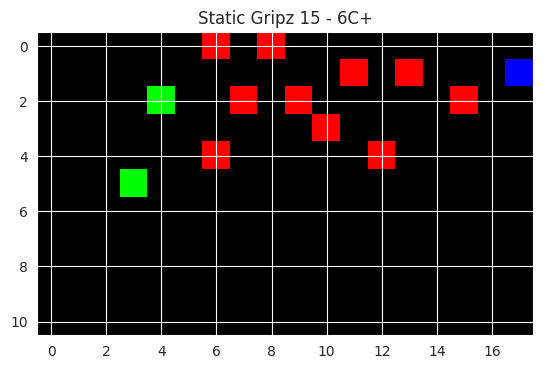

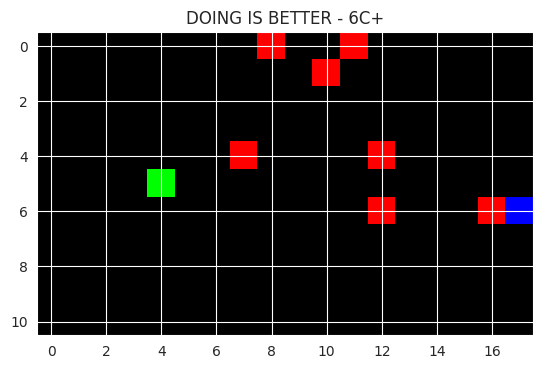

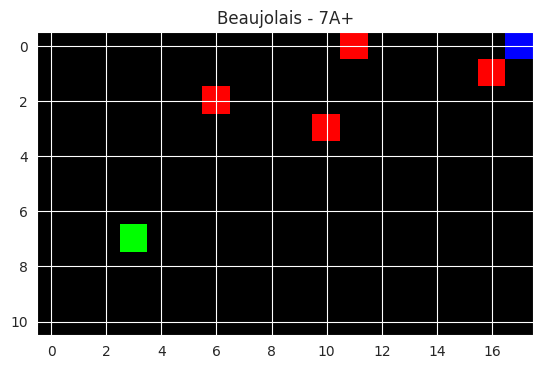

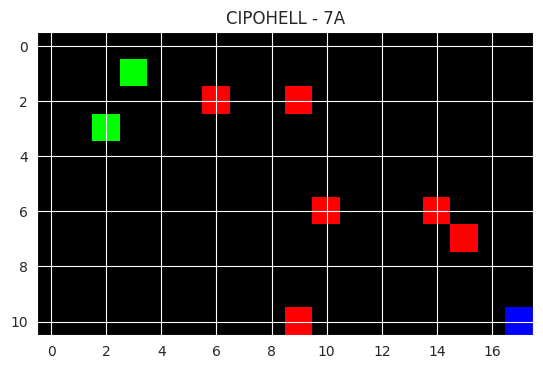

In [38]:
for _, route in df.sample(n=6).iterrows():
  plt.imshow(route['moves'] * 255)
  plt.title(f"{route['name']} - {route['grade']}")
  plt.show()

### Distribution of classes

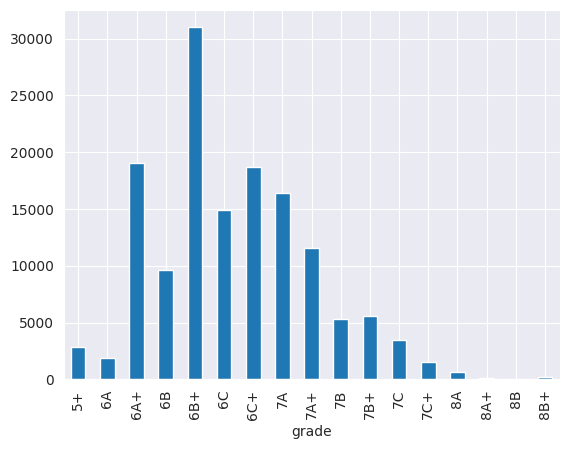

In [40]:
def plot_category_hist(dataframe, cat):
  dataframe[cat].value_counts().sort_index().plot(kind='bar')

plot_category_hist(df, "grade")

Middle-grade routes are over-represented, with 6B+ routes being clearly omnipresent.

### Influence of the method

Let's see another field: "method", describing how the climber should physically solve the problem. This can significantly influence the difficulty and feasibility of a route.

In [41]:
df.groupby('method').size() / len(df)

/tmp/ipykernel_6610/647761904.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('method').size() / len(df)


method
Feet follow hands                0.961579
Feet follow hands + screw ons    0.025618
Footless                         0.000021
Footless + kickboard             0.009553
Screw ons only                   0.003229
dtype: float64

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 [Text(0, 0, '5+'),
  Text(1, 0, '6A'),
  Text(2, 0, '6A+'),
  Text(3, 0, '6B'),
  Text(4, 0, '6B+'),
  Text(5, 0, '6C'),
  Text(6, 0, '6C+'),
  Text(7, 0, '7A'),
  Text(8, 0, '7A+'),
  Text(9, 0, '7B'),
  Text(10, 0, '7B+'),
  Text(11, 0, '7C'),
  Text(12, 0, '7C+'),
  Text(13, 0, '8A'),
  Text(14, 0, '8A+'),
  Text(15, 0, '8B'),
  Text(16, 0, '8B+')])

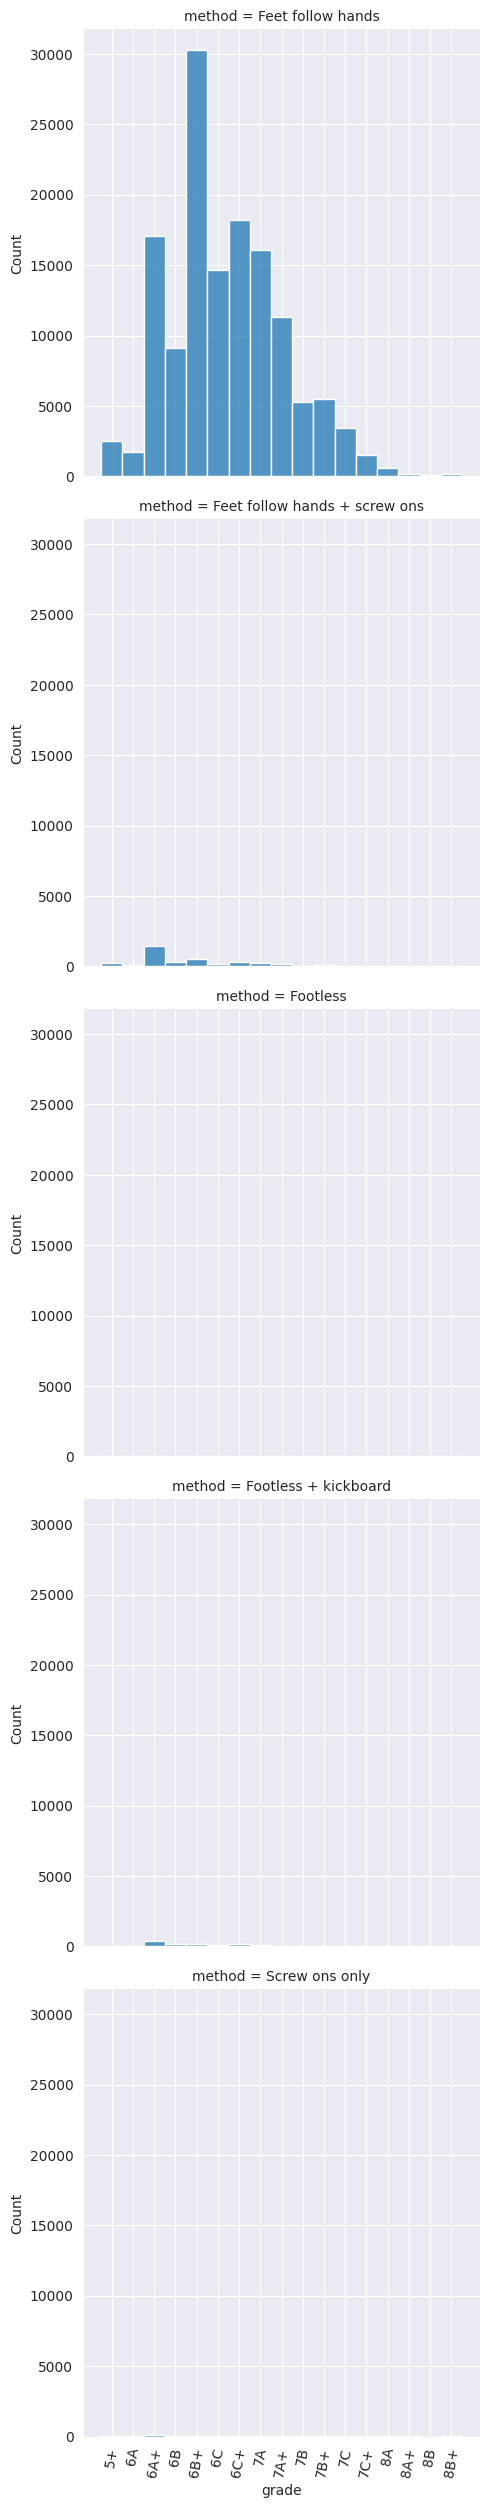

In [42]:
nb_methods = len(df['method'].dtype.categories)

sns.displot(data=df, x='grade', row='method')
plt.xticks(rotation=80)

## Data Preparation

### Separating features and labels

We keep 'moves' separate, as it can be seen as an array of images

In [9]:
features = df.drop(columns=['moves', 'grade', 'name'])
moves = df['moves']
labels = df['grade']

### Rare encoding

For each categorical feature, we group together categories that appear less than 1% of the time.

For instance, the "method" feature has a clear imbalance: thus "footless", "footless + kickboard" and "screw ons only" must be gathered together. We can see this group as "difficult", as the climber is not allowed to use their feet for these routes.

In [10]:
rare_threshold = 0.1

for col in features.select_dtypes(include=['category']):
  value_counts = features[col].value_counts()
  rare_values = list(value_counts[value_counts / len(features) < rare_threshold].index)
  if len(rare_values) > 1:
    features[col] = features[col].cat.add_categories(['Rare'])
    features.loc[features[col].isin(rare_values), col] = 'Rare'
    features[col] = features[col].cat.remove_unused_categories()

### One-hot encoding

Before going further, we need to convert all features except 'moves' to numerical ones.

**Dealing with the "holdsets" feature:**

This field contain arrays of holdsets, so we'll use a one-hot encoding to indicate for each holdset if a route contains it.

In [11]:
# TODO: use https://scikit-learn.org/stable/modules/preprocessing_targets.html ?

def flatten_array(arr):
  result = []
  for el in arr:
    result.extend(el)
  return result

all_sets = list(features['holdsets'].value_counts().index)
all_sets = flatten_array(all_sets)
all_sets = list(set(all_sets))

for i in all_sets:
  features[f'holdset_{i}'] = False

In [12]:
def encode_sets(x):
  for i in x['holdsets']:
    x[f'holdset_{i}'] = True
  return x
  
features = features.apply(encode_sets, axis=1)
features.drop(columns=['holdsets'], inplace=True)

**Dealing with other features:**

In [13]:
features['holdsetup'] = features['holdsetup'].astype('category')
features = pd.get_dummies(features)

labels = pd.get_dummies(labels)

Now that we have all the columns, we can get the number of distinct features and labels:

In [14]:
nb_labels = len(labels.columns)
nb_features = len(features.columns)

### Normalization

We use min-max normalization, as the distribution of numerical inputs (i.e. angle) is not normal

In [15]:
for col in features.select_dtypes(include=[int, float]):
  features[col] = (features[col] - features[col].min()) / (features[col].max() - features[col].min())

### Split into train and test datasets

The validation dataset will be created directly when fitting the model

In [16]:
test_split = 0.2

seed = int(time.time())
def train_test_split(array):
  test = array.sample(frac=test_split, random_state=seed)
  train = array.drop(test.index)
  return train, test

train_features, test_features = train_test_split(features)
train_moves, test_moves = train_test_split(moves)
train_labels, test_labels = train_test_split(labels)

train_moves = np.stack(train_moves.values)
test_moves = np.stack(test_moves.values)

## Helpers to train and analyze models

### Skeleton: build and fit model

We provide helper functions to compile and fit a model.

In [17]:
def compile_model(
        model=None,
        build_function=None,
        learning_rate=1e-3,
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=None):

    if model is None:
        model = build_function()

    if metrics is None:
        metrics=[]

    metrics.extend([
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.TopKCategoricalAccuracy(k=3, name='accuracy_at_three'),
      keras.metrics.TopKCategoricalAccuracy(k=5, name='accuracy_at_five')
    ])

    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate),
        loss=loss,
        metrics=metrics
    )
    print(model.summary())
    return model

In [18]:
def train_model(model,
                training_features,
                training_labels,
                epochs=100,
                callbacks=None,
                early_stopping=None,
                validation_split=0.2,
                batch_size=64,
                name='model',
                log_dir='logs/fit'
                ):

    if callbacks is None:
        callbacks = []
        
    if early_stopping is not None:
        callbacks.append(keras.callbacks.EarlyStopping(monitor='loss', patience=early_stopping))

    date = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    callbacks.extend([
      keras.callbacks.ModelCheckpoint(f'models/{name}{{epoch:02d}}-{{val_loss:.2f}}.keras'),
      keras.callbacks.ModelCheckpoint(f'models/{name}-best.keras', save_best_only=True, monitor='val_loss'),
      keras.callbacks.BackupAndRestore(backup_dir=f'/tmp/backup/{name}--{date}'),
      keras.callbacks.TensorBoard(log_dir=f'{log_dir}/{name}--{date}', histogram_freq=1)
    ])
        
    kwargs = {
      'epochs': epochs,
      'callbacks': callbacks,
      'validation_split': validation_split,
      'batch_size': batch_size,
    }

    model.fit(
      training_features,
      training_labels,
      **kwargs
    )
    return model

### Skeleton: analyze results

In [84]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [108]:
def load_best_model(
        name='model',    
  ):
    best_model = keras.models.load_model(f'models/{name}-best.keras')
    probabilities_labels = baseline_model.predict([test_moves, test_features], verbose=0)
    y_true = np.argmax(test_labels, axis=1)
    y_pred = np.argmax(probabilities_labels, axis=1)
    
    test_predicted = np.zeros_like(probabilities_labels).astype(np.uint8)
    test_predicted[np.arange(probabilities_labels.shape[0]), y_pred] = 1
    
    return best_model, test_predicted, y_true, y_pred

In [109]:
def print_accuracies(model, y_true, y_pred):
  metrics = model.evaluate([test_moves, test_features], test_labels, verbose=0)
  print(f'Accuracy: {metrics[1] * 100:.2f}%')
  print(f'Balanced Accuracy: {balanced_accuracy_score(y_true, y_pred) * 100:.2f}%')
  print(f'Accuracy for Top3: {metrics[2] * 100:.2f}%')
  print(f'Accuracy for Top5: {metrics[3] * 100:.2f}%')

In [111]:
def confusion_matrix_analysis(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  
  per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
  for i, acc in enumerate(per_class_accuracy):
    print(f"Accuracy for grade {all_grades[i]}: {acc * 100:.2f}%")
  
  plt.figure(figsize=(15, 10))
  sns.heatmap(cm_normalized,  annot=True, fmt='.2f', cmap='rocket')
  plt.xlabel("Predicted Labels")
  plt.ylabel("True Labels")
  plt.title("Normalized Confusion Matrix")
  plt.show()

## Baseline

For the baseline, we'll use a simple neural network with only Dense layers.

In [28]:
def create_baseline():
  moves_inputs = keras.Input(shape=MOVES_SHAPE, name="moves")
  features_inputs = keras.Input(shape=(nb_features,), name="features")
  
  x = keras.layers.Flatten()(moves_inputs)
  
  x = keras.layers.concatenate([x, features_inputs])
  
  x = keras.layers.Dense(256, activation='relu')(x)
  x = keras.layers.Dense(64, activation='relu')(x)
  x = keras.layers.Dropout(0.5)(x)
  outputs = keras.layers.Dense(nb_labels, activation='softmax')(x)
  
  return keras.Model(inputs=[moves_inputs, features_inputs], outputs=outputs)
  
baseline_model = compile_model(build_function=create_baseline)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ moves (InputLayer)  │ (None, 11, 18, 3) │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 594)       │          0 │ moves[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ features            │ (None, 14)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 608)       │          0 │ flatten_1[0][0],  │
│ (Concatenate)       │                   │            │ features[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │    155,904 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │     16,448 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 17)        │      1,105 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 173,457 (677.57 KB)

 Trainable params: 173,457 (677.57 KB)

 Non-trainable params: 0 (0.00 B)

None


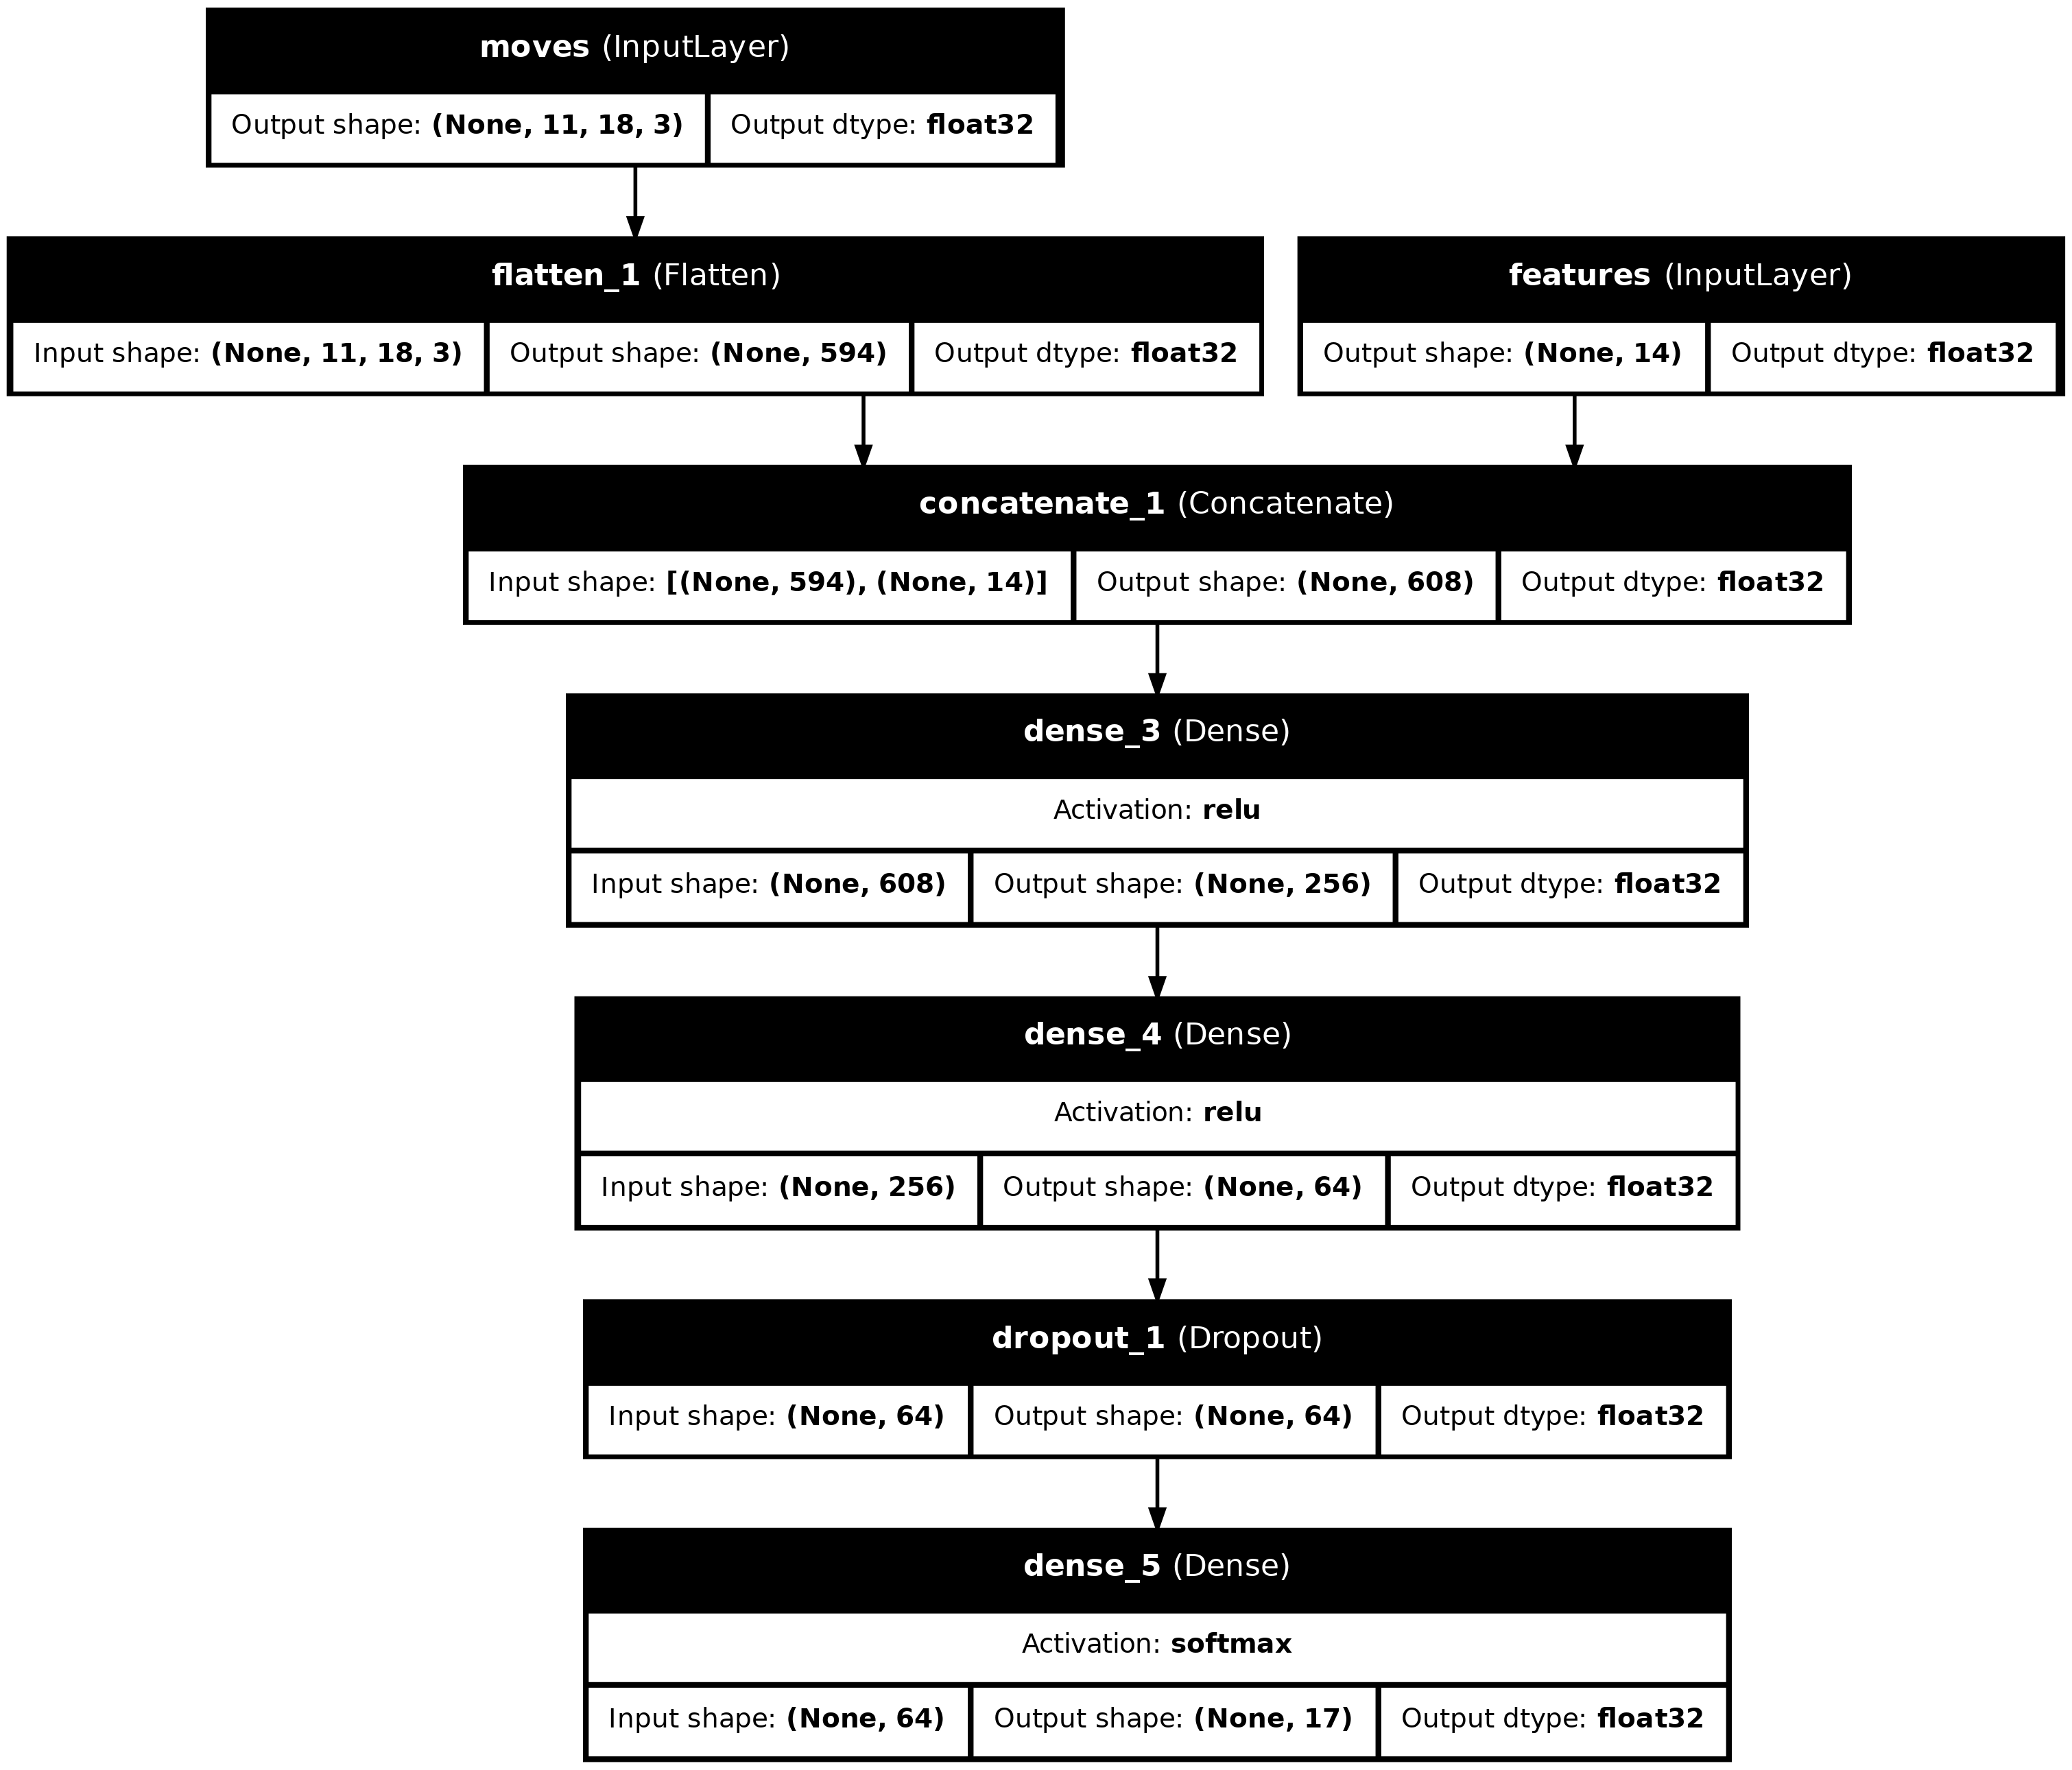

In [29]:
keras.utils.plot_model(
  baseline_model,
  show_shapes=True,
  show_dtype=True,
  show_layer_names=True,
  show_layer_activations=True,
  expand_nested=True
)

### Model training

In [34]:
train_model(
  model=baseline_model,
  name='baseline',
  training_features=[np.stack(train_moves.values), train_features],
  training_labels=train_labels,
  epochs=50,
  early_stopping=3
)

Epoch 1/50


I0000 00:00:1724850969.850950   23742 service.cc:146] XLA service 0x7ff5b0008670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724850969.850978   23742 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1050, Compute Capability 6.1
2024-08-28 15:16:09.909687: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-28 15:16:10.101404: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  10/1431 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.0963 - accuracy_at_five: 0.4537 - accuracy_at_three: 0.3003 - loss: 2.7088    

I0000 00:00:1724850971.684671   23742 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1431/1431 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.3135 - accuracy_at_five: 0.8059 - accuracy_at_three: 0.6155 - loss: 1.9443 - val_accuracy: 0.1963 - val_accuracy_at_five: 0.7147 - val_accuracy_at_three: 0.4818 - val_loss: 2.3583
Epoch 2/50
1431/1431 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.3824 - accuracy_at_five: 0.8994 - accuracy_at_three: 0.7355 - loss: 1.6275 - val_accuracy: 0.1921 - val_accuracy_at_five: 0.6647 - val_accuracy_at_three: 0.4565 - val_loss: 2.6150
Epoch 3/50
1431/1431 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.3977 - accuracy_at_five: 0.9130 - accuracy_at_three: 0.7521 - loss: 1.5895 - val_accuracy: 0.1926 - val_accuracy_at_five: 0.6792 - val_accuracy_at_three: 0.4675 - val_loss: 2.5794
Epoch 4/50
1431/1431 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.4041 - accuracy_at_five: 0.9190 - accuracy_at_three: 0.7638 - loss: 1.5662 - val_accuracy: 0.1891 - val_accuracy_at_five: 0.6795 - val_accuracy_at_three: 0.4618 - val_loss: 2.6829
Epoch 5/50
1431/1

<Functional name=functional_1, built=True>

In [110]:
baseline_model, test_predicted, y_true, y_pred = load_best_model('model')

### Accuracy

In [87]:
print_accuracies(baseline_model, y_true, y_pred)

Accuracy: 173.95%
Balanced Accuracy: 17.62%
Accuracy for Top3: 34.81%
Accuracy for Top5: 68.74%


Our model is overfitting straight away: it's not able to detect any patterns, so it learns the training dataset by heart.

### Confusion matrix

Accuracy for grade 5+: 70.52%
Accuracy for grade 6A: 2.99%
Accuracy for grade 6A+: 61.38%
Accuracy for grade 6B: 4.88%
Accuracy for grade 6B+: 77.37%
Accuracy for grade 6C: 0.00%
Accuracy for grade 6C+: 5.68%
Accuracy for grade 7A: 39.93%
Accuracy for grade 7A+: 29.04%
Accuracy for grade 7B: 0.00%
Accuracy for grade 7B+: 7.77%
Accuracy for grade 7C: 0.00%
Accuracy for grade 7C+: 0.00%
Accuracy for grade 8A: 0.00%
Accuracy for grade 8A+: 0.00%
Accuracy for grade 8B: 0.00%
Accuracy for grade 8B+: 0.00%


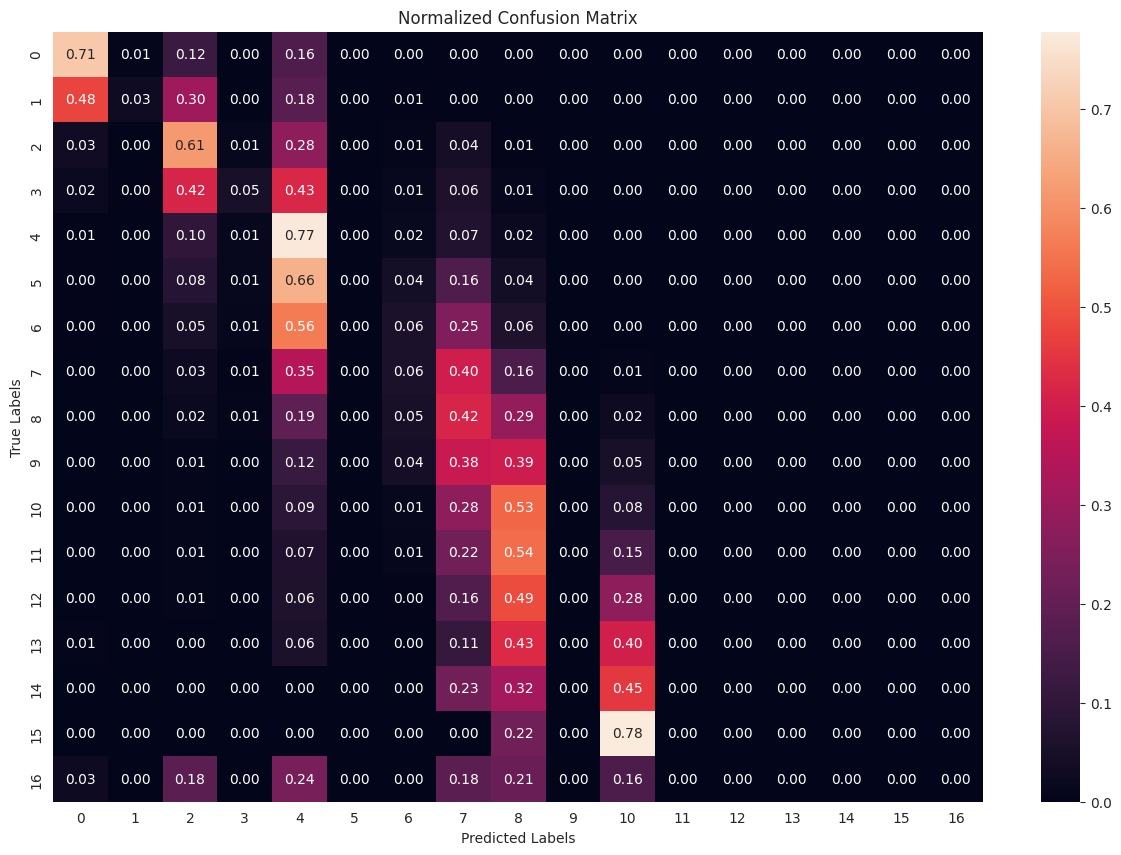

In [112]:
confusion_matrix_analysis(y_true, y_pred)

## Combine under-sampling and over-sampling

We'll try to keep all counts in range [10000; 20000] except for extreme classes (8A and further).

As a reminder, here is the distribution of classes in our dataset:

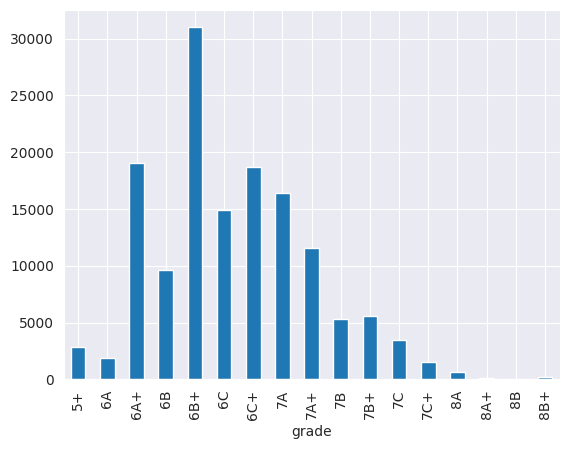

In [82]:
plot_category_hist(df, "grade")

In [83]:
from imblearn.combine import SMOTEENN

sampling_strategy = {
  '5+': 10_000,
  '6A': 10_000,
  '6A+': 15_000,
  '6B': 15_000,
  '6B+': 20_000,
  '6C': 15_000,
  '6C+': 15_000,
  '7A': 15_000,
  '7A+': 10_000,
  '7B': 10_000,
  '7B+': 10_000,
  '7C': 10_000,
  '7C+': 10_000,
  '8A': 5_000,
  '8A+': 5_000,
  '8B': 5_000,
  '8B+': 5_000,
}

sampler = SMOTEENN(sampling_strategy=sampling_strategy)
X_resampled, y_resampled = sampler.fit_resample(features, labels)

ValueError: With over-sampling methods, the number of samples in a class should be greater or equal to the original number of samples. Originally, there is 19014 samples and 15000 samples are asked.

In [ ]:
plot_category_hist(dataset, 'grade')

## Explainability

## Conclusions